# Titanic 

In this notebook we will experiment with tabular data and fastai v2 and other machine learning techniques


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fastai.tabular.all import *
from pathlib import Path
import seaborn as sns
sns.set_palette('Set1')
sns.set_style("white")

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

In [2]:
path = Path('/home/jupyter/kaggle/titanic/')
train = pd.read_csv(path/'train.csv')
test = pd.read_csv(path/'test.csv')

Let's take a look of the data composing the dataset

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Notes about the columns:

| Column name | Description |
|---|---|
| PassangerID | Unique identifier for each passanger | 
|  Survived |  1 survived, 0 did not survive | 
|  Pclass | From the problem description:  A proxy for socio-economic status (SES) 1 = Upper ,2= Middle, 3 = Lower |
|  Name |  Name of the passanger | 
|  Sex |  Sex of passanger | 
|  Age |  Age of the passanger, if younger than 1 it will be fractionary | 
| SibSp |  Number of brothers, sisters, stepbrother, stepsister and wife or husband of the given passanger embarked | 
| Parch |  Number of parents or children embarked of the passanger | 
|  Ticket |  Ticket number | 
|  Cabin |  Cabin number | 
|  Embarked | Port of embarkation -> C = Cherbourg, Q = Queenstown, S = Southampton | 

Before preparing the data for our model, let's take a look how each column influences survivality

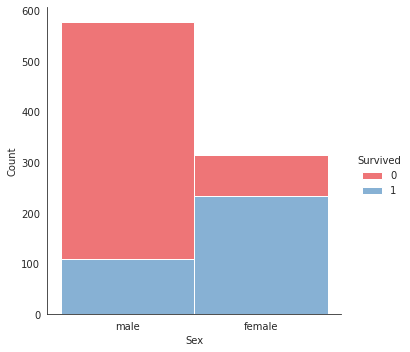

In [4]:

sns.displot(data=train, x='Sex', hue='Survived', multiple = 'stack',alpha=0.6)

There is almost double male than female passengers but there is much more female survivors. Next let's take a look how the passengers where distributed among the classes and age.

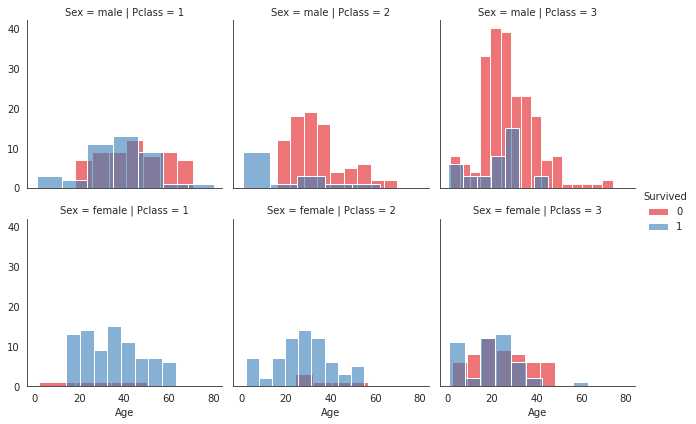

In [5]:
g = sns.FacetGrid(train, col='Pclass',row='Sex',hue='Survived', )
g.map(sns.histplot,'Age', alpha=0.6)
g.add_legend()

1st and 2nd class female passengers where much more likely to survive than male passengers from 2nd and 3rd class.

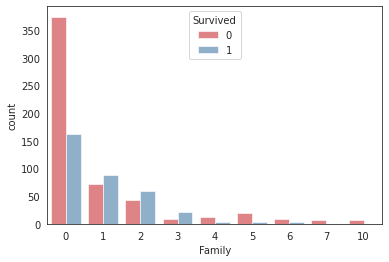

In [6]:
train['Family']=(train['SibSp']+train['Parch']).astype(int)
order=[]
for i in range(10):
    order.append(str(i))
a=sns.countplot(data=train, x='Family', hue='Survived',dodge=True, alpha=0.6)

There are many passengers travelling alone and they are much less likely to survive. Then people who had between 2 and 3 relatives was more likely to survive than the rest of passengers.

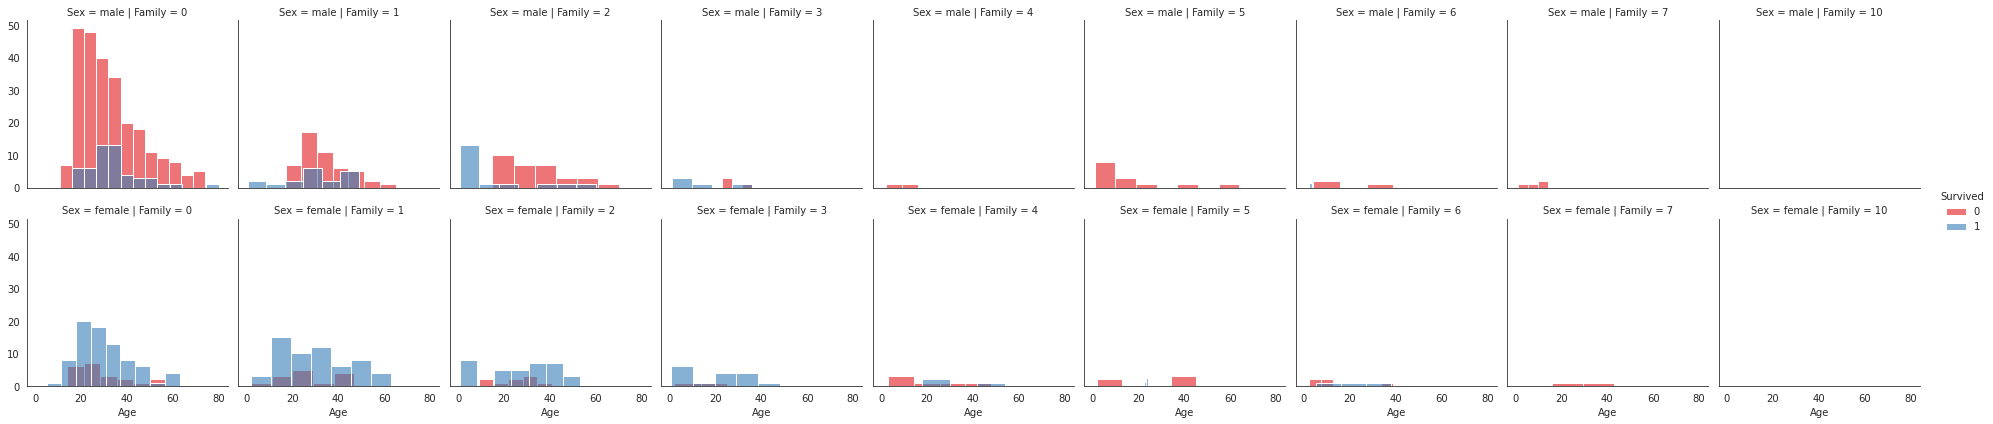

In [7]:
g = sns.FacetGrid(train, col='Family',row='Sex',hue='Survived', )
g.map(sns.histplot,'Age', alpha=0.6)
g.add_legend()

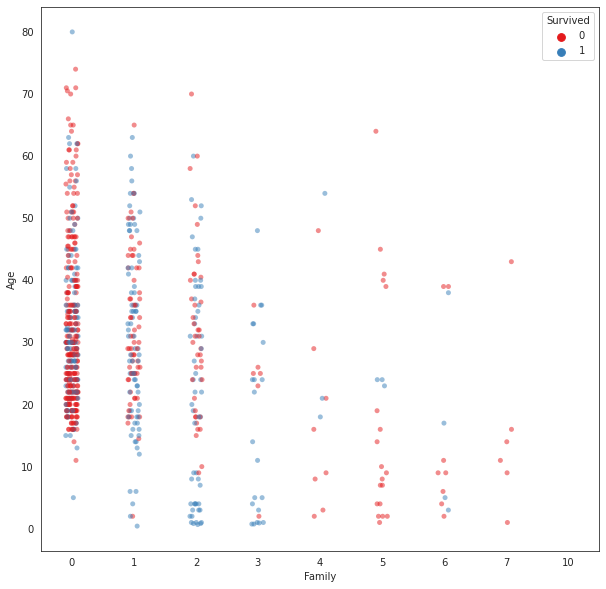

In [8]:
plt.figure(figsize=(10,10))
a=sns.stripplot(data=train, x='Family', y='Age', hue='Survived', alpha=0.5)

There are some columns not very useful predicting the survival rate of a given passanger, these are: 'PassengerId', 'Name', 'Ticket' and 'Fare'. We will remove this columns. 

In [9]:
def remove_cols(df, cols, debug=False):
    df.drop(columns = cols, inplace=True);
    if debug: print('columns_droped')
    return(df)

In [10]:
cols = ['PassengerId', 'Ticket', 'Fare','Name']
print(f'This features:{cols} will be removed from the data set')

This features:['PassengerId', 'Ticket', 'Fare', 'Name'] will be removed from the data set


We can check the unique values the dataset takes for each column

In [11]:
print('Number of unique classes in each feature: ')
print(train.nunique())


Number of unique classes in each feature: 
PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
Family           9
dtype: int64


We can take a look of the missing values in the columns, we can se there is missing data in 'Age' and 'Cabin'. 

In [12]:
print('Number of passengers missing each feature:')
train.isna().sum()

Number of passengers missing each feature:


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Family           0
dtype: int64

We will create a new column indicating is that the data is missing and impute the **mean age of the training set** and fill cabin with the text 'Missing'. 
Cabin might look as it is not relevant but the letter of leading the number can indicate the deck it was and might be relevant to the survivality. There are also 2 passengers missing where they embarked, this can be very relevant so we will create a new column for missing embarkation port. This might be relevant because it could be very easy to retrieve this information from the survivors. So instead of keeping the whole cabin number, we will just save the cabin letter.

In [13]:
MEAN_AGE = train['Age'].mean()
def fill_na(df,debug=False):
    df.loc[:,'AgeMissing'] = df['Age'].isna() # New column for missing data
    if debug: print('fillna complete: 1/4')
    df['Age'].fillna(MEAN_AGE, inplace=True) #filling 'Age' with the mean 
    if debug: print('fillna complete: 2/4')
    df['Cabin'].fillna('Missing', inplace=True)
    if debug: print('fillna complete: 3/4')
    df['Cabin'] = df['Cabin'].apply(lambda x: x[0])
    if debug: print('fillna complete')
    return df

Next is to convert all categorical feature columns to multiple binnary columns using [one hot encoding](https://en.wikipedia.org/wiki/One-hot 'One-hot
From Wikipedia, the free encyclopedia') technique. Each category in a given feature will be a new column.

In [14]:
OHE_COLS = ['Pclass', 'Sex','Cabin']
def ohe_data(df, columns):
    new_pd = pd.get_dummies(df)
    return new_pd    

In [15]:
def prepare_data(df, cols, ohe_cols, debug=False):
    df = df.copy()
    df = remove_cols(df, cols,debug)
    df = fill_na(df, debug)
    df['Pclass'] = df['Pclass'].astype(str)
    df = ohe_data(df, ohe_cols)
    return df

In [16]:
df_test = pd.read_csv('test.csv')
full = pd.concat([train,df_test])

In [17]:
full_clean = prepare_data(full, cols, OHE_COLS,True)

columns_droped
fillna complete: 1/4
fillna complete: 2/4
fillna complete: 3/4
fillna complete


In [18]:
train_clean = full_clean.iloc[:len(train)].copy()
train_clean1 = train_clean.copy()
test_clean = full_clean.iloc[-len(test):].copy()

In [19]:
y = train_clean['Survived']

In [20]:
train_clean.drop(columns='Survived', inplace=True)

With the data cleaned we can train the classifier. First we need a validation set to check the performance of the classifier with data not used in training

In [21]:
x_train, x_val, y_train, y_val = train_test_split(train_clean,y, test_size=0.2, random_state=42)

In [22]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)

In [23]:
clf.fit(x_train,y_train)

GradientBoostingClassifier(max_depth=4, random_state=42)

In [24]:
clf.score(x_val,y_val)

0.8268156424581006

In [25]:
clf.feature_importances_

array([0.196895  , 0.03701054, 0.00821784, 0.07522325, 0.00334779,
       0.00432062, 0.00666312, 0.12445947, 0.27777409, 0.15556888,
       0.00767302, 0.00312347, 0.00811825, 0.00690645, 0.01019694,
       0.00303809, 0.00425221, 0.03661539, 0.00028137, 0.01080579,
       0.00369918, 0.01580923])

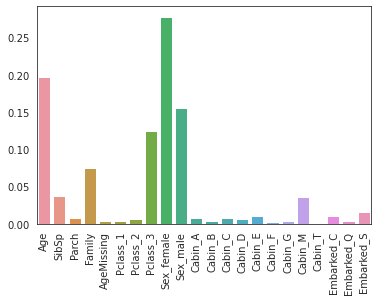

In [26]:
chart=sns.barplot(x=train_clean.columns, y=clf.feature_importances_,);
chart.set_xticklabels(train_clean.columns,rotation=90);

In [27]:
submission = pd.read_csv('gender_submission.csv')

In [28]:
test_clean.drop(columns='Survived', inplace=True)

In [29]:
test_clean['Family']=(test_clean['SibSp']+test_clean['Parch']).astype(int)

In [30]:
y_sub = clf.predict(test_clean)

In [31]:
submission['Survived']=y_sub.astype(int)

In [32]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [33]:
submission.to_csv('sub.csv',index=False)

In [34]:
#!kaggle competitions submit titanic -f sub.csv -m "first submision"

Let's try a more sophisticated method using Fast.ai library

In [88]:
path = Path('/home/jupyter/kaggle/titanic/')
train = pd.read_csv(path/'train.csv')
test = pd.read_csv(path/'test.csv')

In [60]:
train.drop(columns=['PassengerId','Ticket','Name'],inplace = True)
test.drop(columns=['PassengerId','Ticket','Name'],inplace = True)


In [61]:
train['Cabin'] = train['Cabin'].fillna(value='Missing')
test['Cabin'] = train['Cabin'].fillna(value='Missing')

In [62]:
train['Cabin'] = train['Cabin'].apply(lambda x:x[0])
test['Cabin'] = train['Cabin'].apply(lambda x:x[0])


In [63]:
train['Cabin']

0      M
1      C
2      M
3      C
4      M
      ..
886    M
887    B
888    M
889    C
890    M
Name: Cabin, Length: 891, dtype: object

In [134]:
y_names = 'Survived'
cat_names = ['Pclass','Sex','Cabin', 'Embarked']
cont_names = ['Age', 'SibSp','Parch',]
procs = [ Categorify, FillMissing, Normalize]
splits = RandomSplitter(valid_pct=0.2)(range_of(train_clean1))

In [135]:
to = TabularPandas(df=train, 
                   cat_names=cat_names, 
                   cont_names=cont_names, 
                   procs=procs,
                   y_names=y_names, 
                   splits=splits,
                   y_block= CategoryBlock,)

In [136]:
dls = to.dataloaders(bs=64)

In [137]:
dls.show_batch()

,Pclass,Sex,Cabin,Embarked,Age_na,Age,SibSp,Parch,Survived
0,1,male,#na#,S,False,50.000000,2.000000e+00,6.594756e-09,1
1,3,male,#na#,S,False,39.000000,1.000000e+00,5.000000e+00,0
2,3,male,#na#,S,False,35.000000,1.080337e-08,6.594756e-09,0
3,3,female,#na#,S,False,2.000001,3.000000e+00,2.000000e+00,0
4,3,male,#na#,S,False,39.000000,1.080337e-08,6.594756e-09,0
5,1,male,E17,S,False,50.999999,1.080337e-08,6.594756e-09,1
6,3,male,#na#,S,False,34.000000,1.000000e+00,1.000000e+00,0
7,2,female,#na#,S,False,29.000000,1.000000e+00,6.594756e-09,1
8,3,female,#na#,S,False,27.000000,1.080337e-08,2.000000e+00,1
9,2,male,#na#,S,False,70.000001,1.080337e-08,6.594756e-09,0


In [150]:
learn = tabular_learner(dls, metrics=[ accuracy])

In [151]:
learn.fit_one_cycle(10,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.681752,0.686645,0.668539,00:00
1,0.596691,0.648901,0.691011,00:00
2,0.514714,0.603037,0.679775,00:00
3,0.454453,0.562806,0.719101,00:00
4,0.411442,0.515760,0.792135,00:00
5,0.381588,0.455279,0.831461,00:00
6,0.362296,0.439527,0.803371,00:00
7,0.347051,0.460097,0.803371,00:00
8,0.337407,0.489180,0.803371,00:00
9,0.328262,0.509232,0.803371,00:00


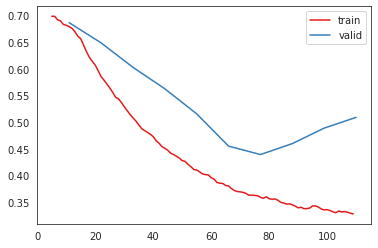

In [152]:
learn.recorder.plot_loss()

In [96]:
learn.save('9epoch')

Path('models/9epoch.pth')

In [97]:
learn.show_results()

,Pclass,Sex,Cabin,Embarked,Age_na,Age,SibSp,Parch,Survived,Survived_pred
0,3.0,2.0,0.0,3.0,1.0,-0.901338,-0.476557,-0.461321,0.0,0.0
1,3.0,1.0,0.0,3.0,1.0,0.030381,-0.476557,-0.461321,1.0,0.0
2,3.0,1.0,0.0,3.0,1.0,-1.988343,-0.476557,1.966146,1.0,1.0
3,2.0,2.0,0.0,3.0,2.0,-0.124905,-0.476557,-0.461321,0.0,0.0
4,3.0,1.0,0.0,3.0,1.0,-1.677770,2.248993,0.752413,0.0,0.0
5,1.0,1.0,29.0,1.0,1.0,1.117386,-0.476557,-0.461321,1.0,1.0
6,1.0,1.0,95.0,3.0,1.0,1.505603,-0.476557,-0.461321,1.0,1.0
7,3.0,2.0,0.0,3.0,1.0,-2.221273,3.157510,0.752413,0.0,0.0
8,1.0,2.0,0.0,3.0,1.0,0.340954,-0.476557,-0.461321,1.0,0.0


In [117]:
dl_test=learn.dls.test_dl(test)

In [123]:
probs,_ =learn.get_preds(dl=dl_test)

In [129]:
y = np.argmax(probs,1)
y = np.array(y)

In [132]:
submission['Survived']=y.astype(int)

In [133]:
submission.to_csv('sub.csv',index=False)
!kaggle competitions submit titanic -f sub.csv -m "first submision"

100%|██████████████████████████████████████| 2.77k/2.77k [00:02<00:00, 1.37kB/s]
Successfully submitted to Titanic: Machine Learning from Disaster